# Analysis of Salary Requirements and Inflation (2018–2025)

## Introduction

The Finnish Immigration Service (Migri) updates the minimum salary requirements annually. For individuals and organizations affected by these changes, staying informed about trends and predictions is crucial.

This notebook analyzes salary requirements for various residence permits, such as the Specialist, or the EU Blue Card, alongside inflation data in Finland from 2018 to 2025. The goal is to uncover trends and provide a foundation for forecasting future salary requirements.

### Import libraries and setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
file_path = '../data/migri_residence_premit_salary_requirements_2018_2025.csv'
min_salaries_df = pd.read_csv(file_path)
min_salaries_df['archive_date'] = pd.to_datetime(min_salaries_df['archive_date'], format='%d.%m.%Y')

In [3]:
print("Data Preview:")
min_salaries_df.sample(5)

Data Preview:


,archive_date,year,amount,type,archive_url
17,2021-10-18,2021,4929,eu-n-sininenkortti,https://web.archive.org/web/20211018082255/htt...
12,2024-04-15,2024,5457,eu-n-sininenkortti,https://web.archive.org/web/20240415231053/htt...
0,2025-01-04,2025,3827,erityisasiantuntija,https://web.archive.org/web/20250104213951/htt...
32,2019-06-24,2019,1211,tyontekijan-oleskelulupa,https://web.archive.org/web/20190624111418/htt...
28,2023-10-03,2023,1331,tyontekijan-oleskelulupa,https://web.archive.org/web/20231003014901/htt...


In [4]:
# Dictionary for translation
translation_dict = {
    'tyontekijan-oleskelulupa': 'Residence permit application for an employed person (TTOL)',
    'erityisasiantuntija': 'Specialist',
    'eu-n-sininenkortti': 'EU Blue Card'
}

# Add the new column with translations
min_salaries_df['type_en'] = min_salaries_df['type'].map(translation_dict)

min_salaries_df.sample(5)

,archive_date,year,amount,type,archive_url,type_en
23,2019-01-14,2019,4732,eu-n-sininenkortti,https://web.archive.org/web/20190114205503/htt...,EU Blue Card
13,2023-09-21,2023,5209,eu-n-sininenkortti,https://web.archive.org/web/20230921131802/htt...,EU Blue Card
2,2023-03-27,2023,3473,erityisasiantuntija,https://web.archive.org/web/20230327221202/htt...,Specialist
15,2022-12-07,2022,5069,eu-n-sininenkortti,https://web.archive.org/web/20221207174531/htt...,EU Blue Card
12,2024-04-15,2024,5457,eu-n-sininenkortti,https://web.archive.org/web/20240415231053/htt...,EU Blue Card


In [5]:
print("\nData Information:")
min_salaries_df.info()


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   archive_date  34 non-null     datetime64[ns]
 1   year          34 non-null     int64         
 2   amount        34 non-null     int64         
 3   type          34 non-null     object        
 4   archive_url   34 non-null     object        
 5   type_en       34 non-null     object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.7+ KB


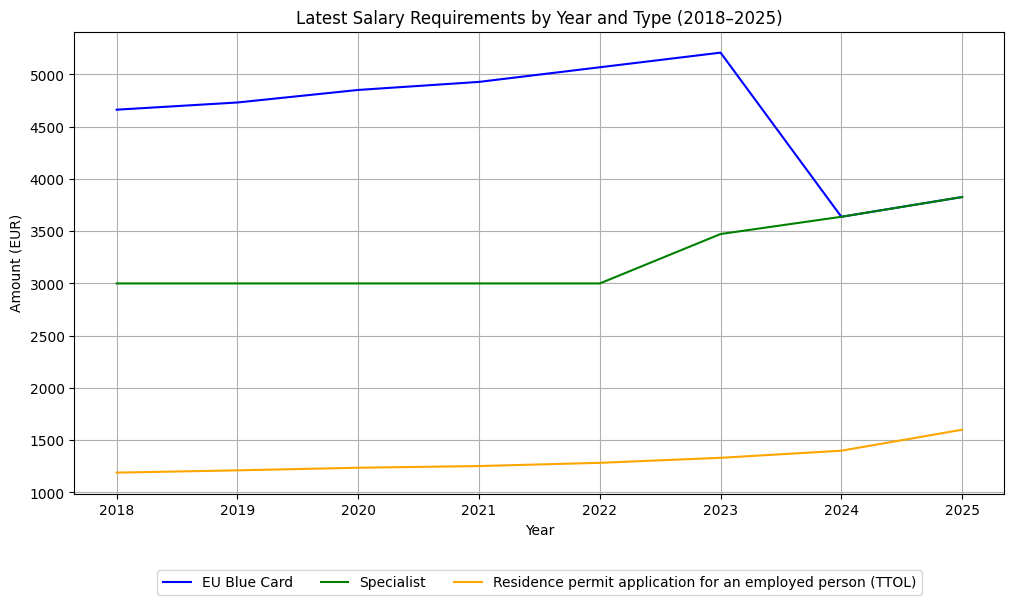

In [6]:
# Sort by year and archive_date to get the latest entry for each year
latest_salaries_df = min_salaries_df.sort_values(by=['year', 'archive_date'], ascending=[True, False]).drop_duplicates(subset=['year', 'type'])

# Define colors for each type
colors_dic = {
    'EU Blue Card': 'blue',
    'Specialist': 'green',
    'Residence permit application for an employed person (TTOL)': 'orange'
}

# Plot the data
plt.figure(figsize=(12, 6))
for key, grp in latest_salaries_df.groupby('type_en'):
    plt.plot(grp['year'], grp['amount'], label=key, color=colors_dic[key])

plt.xlabel('Year')
plt.ylabel('Amount (EUR)')
plt.title('Latest Salary Requirements by Year and Type (2018–2025)')

# Custom legend order
handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index('EU Blue Card'), labels.index('Specialist'), labels.index('Residence permit application for an employed person (TTOL)')]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)

plt.grid(True)
plt.show()